In [1]:
import warnings
warnings.filterwarnings('ignore')

# <br>**Part 1: Model Optimization Through Hyperparameters**

## **Importando os dados**

In [7]:
from sklearn.model_selection import cross_validate, GroupKFold, GridSearchCV, KFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline

In [8]:
uri= "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados= pd.read_csv(uri).drop(columns= ['Unnamed: 0'])
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


## **Modelagem**

In [9]:
# SIMULANDO SITUACAO HORRIVEL DE AZAR (CLASSES ORDENADAS POR PADRAO)
dados_azar= dados.sort_values('vendido', ascending= True)
x_azar= dados_azar[['preco', 'idade_do_modelo', 'km_por_ano']]
y_azar= dados_azar['vendido']
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


#### Na prática, às vezes utilizamos um DummyClassifier() como linha de base, e às vezes escolhemos um algoritimo simples para essa mesma função. Pode ser preferível rodar os dois, tanto um dummy quanto um algoritmo mais inteligente, pois existem situações em que o algoritmo mais inteligente realmente não se encaixa com aquele modelo.

In [10]:
# BASELINE COM DUMMY (DummyClassifier)
SEED= 301
np.random.seed(SEED)

model= DummyClassifier(strategy= 'stratified')
results= cross_validate(model, x_azar, y_azar, cv= 10, return_train_score= False)
media= results['test_score'].mean()
desvio_padrao= results['test_score'].std()
print("Accuracy dummy stratified, cv 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy dummy stratified, cv 10 = [49.79, 53.45]


In [11]:
# BASELINE COM ALGORITIMO INTELIGENTE (DecisionTreeClassifier)
SEED= 301
np.random.seed(SEED)

model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x_azar, y_azar, cv= 10, return_train_score= False)
media= results['test_score'].mean()
desvio_padrao= results['test_score'].std()
print("Accuracy decision tree, cv 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy decision tree, cv 10 = [73.83, 77.73]


In [12]:
# GERANDO DADOS ALEATORIOSDE MODELO DE CARRO PARA SIMULACAO DE AGRUPAMENTO AO USAR O ESTIMADOR
np.random.seed(SEED)
dados['modelo']= dados['idade_do_modelo'] + np.random.randint(-2, 3, size= 10000)
dados['modelo']= dados['modelo'] + abs(dados['modelo'].min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [13]:
# CRIANDO A FUNCAO print_results
def print_results(results):
    media= results['test_score'].mean()
    desvio_padrao= results['test_score'].std()
    print("Accuracy mean: %.2f" % (media*100))
    print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

In [14]:
# GROUP KFOLD PARA ANALISAR COMO O MODELO SE COMPORTA COM NOVOS GRUPOS
SEED= 301
np.random.seed(SEED)

cv_generator= GroupKFold(n_splits= 10)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= False)

print_results(results)

Accuracy mean: 75.78
Accuracy interval: [73.67, 77.90]


In [15]:
# GROUP KFOLD EM UM PIPELINE COM StandardScaler e SVC
SEED= 301
np.random.seed(SEED)

cv_generator= GroupKFold(n_splits= 10)
scaler= StandardScaler()
model= SVC()
pipeline= Pipeline([('Scaler', scaler), ("Estimator", model)])
results= cross_validate(pipeline, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= False)

print_results(results)

Accuracy mean: 76.68
Accuracy interval: [74.28, 79.08]


#### Agora, para o próximo passo, vamos utilizar o DecisionTreeClassifier(). Vamos copiar o código e rodá-lo novamente, obtendo a variável modelo, que é justamente o nosso DecisionTreeClassifier().

In [11]:
SEED= 301
np.random.seed(SEED)

cv_generator= GroupKFold(n_splits= 10)
model= DecisionTreeClassifier(max_depth= 2)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= False)

print_results(results)

Accuracy mean: 75.78
Accuracy interval: [73.67, 77.90]


In [12]:
model

DecisionTreeClassifier(max_depth=2)

#### Agora, quando rodarmos o código para imprimir a visualização da nossa árvore de decisão... teremos um erro dizendo que nossa árvore de decisão ainda não foi treinada. <br><br>*'NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.'*<br><br> Porém, nós fizemos a validação cruzada desse modelo, certo? Na verdade, quando fazemos 10 vezes a validação cruzada (KFold com n_splits= 10), resultamos em 10 modelos diferentes. E qual desses 10 modelos queremos usar? Essa é uma pergunta delicada, e a resposta é que não queremos utilizar nenhum deles. Na validação cruzada, nós treinamos o algoritmo 10 vezes para termos uma estimativa de quão bem esse modelo funcionaria no mundo real. Agora queremos esse modelo **DE VERDADE** para podermos usar no mundo real. <br><br>Portanto, vamos pegar nosso modelo e treiná-lo com x_azar e y_azar.

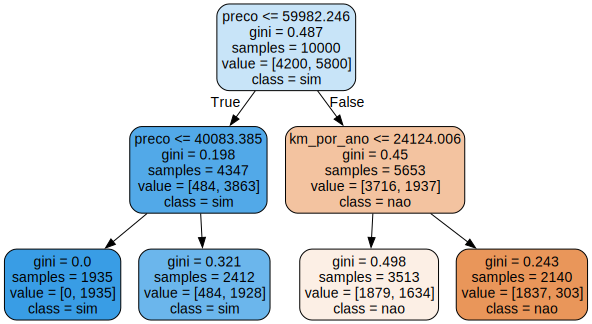

In [13]:
# TREINANDO O MODELO (DecisionTreeClassifier) E O VISUALIZANDO ATRAVES DO GRAPHVIZ
model.fit(x_azar, y_azar)
dot_data= export_graphviz(model, filled= True, rounded= True, class_names= ['nao', 'sim'], feature_names= x_azar.columns)
graphviz.Source(dot_data)

In [14]:
# TREINANDO O MODELO (DecisionTreeClassifier) E O VISUALIZANDO ATRAVES DO GRAPHVIZ, POREM AGORA COM max_depth= 3 AO INVES DE 2
SEED= 301
np.random.seed(SEED)

cv_generator= GroupKFold(n_splits= 10)
model= DecisionTreeClassifier(max_depth= 3)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= False)

print_results(results)

Accuracy mean: 78.67
Accuracy interval: [76.40, 80.94]


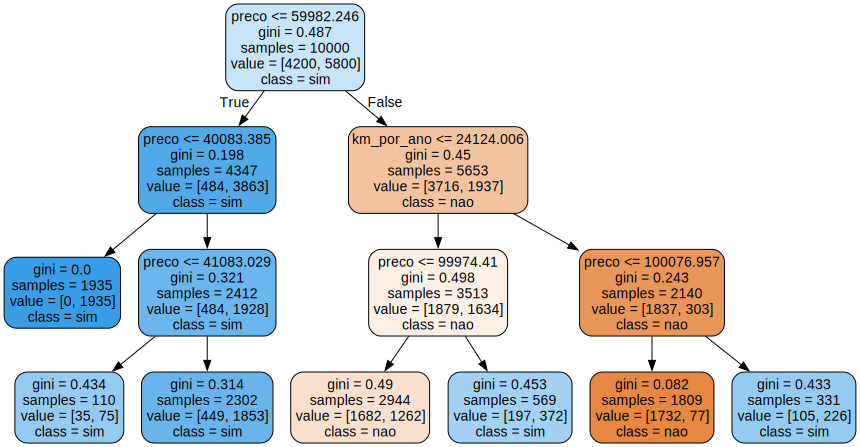

In [15]:
model.fit(x_azar, y_azar)
dot_data= export_graphviz(model, filled= True, rounded= True, class_names= ['nao', 'sim'], feature_names= x_azar.columns)
graphviz.Source(dot_data)

#### Será então que, quanto maior o max_depth, melhores serão os resultados? Para testar isso, vamos repetir o processo, dessa vez com max_depth= 10.

In [16]:
# TREINANDO O MODELO (DecisionTreeClassifier) E O VISUALIZANDO ATRAVES DO GRAPHVIZ, POREM AGORA COM max_depth= 10
SEED= 301
np.random.seed(SEED)

cv_generator= GroupKFold(n_splits= 10)
model= DecisionTreeClassifier(max_depth= 10)
results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= False)

print_results(results)

Accuracy mean: 77.19
Accuracy interval: [75.26, 79.13]


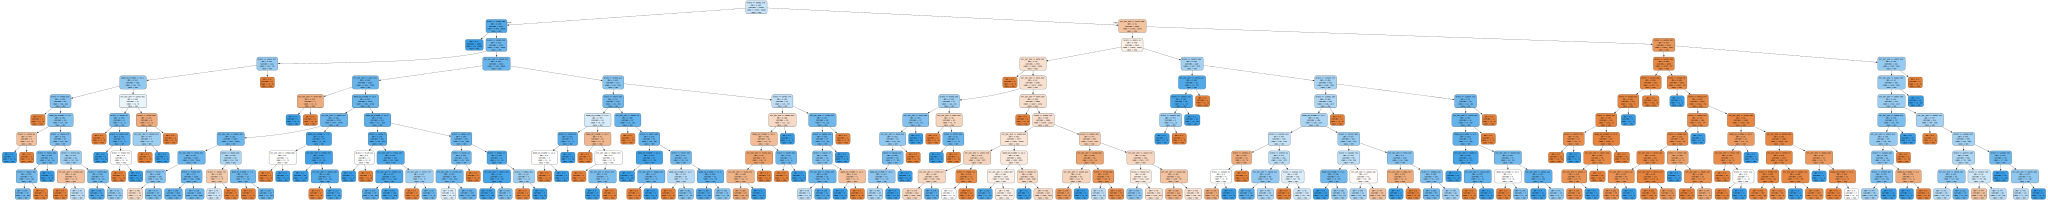

In [17]:
model.fit(x_azar, y_azar)
dot_data= export_graphviz(model, filled= True, rounded= True, class_names= ['nao', 'sim'], feature_names= x_azar.columns)
graphviz.Source(dot_data)

#### Nosso resultado com max_depth= 10 será:<br><br>Accuracy médio 77.19<br>Intervalo [75.26, 79.13]<br><br>Ou seja, obtemos valores piores do que os que tínhamos conseguido anteriormente (max_depth= 3), e a visualização gerada é tão grande que mal cabe na tela do computador.<br>O ponto é: na documentação do SkLearn DecisionTreeClassifier encontramos a informação de que ele tem um parâmetro, chamado max_depth, que pode ser setado para o número que quisermos. Mas como escolhemos esse número, que influencia em quão bem o nosso algorítimo irá rodar?<br>Outros classificadores, como o SVC, também possuem parâmetros que interferem nos resultados do algorítimo. O nosso objetivo nesse curso é entendermos como escolher esses parâmetros para otimizar o nosso estimador. 

## <br>**Explorando hiper parametros em uma dimensao**
#### 1 dimensao = 1 hiper parametro

#### Anteriormente, aprendemos que podemos fornecer parâmetros para nossos estimadores/classificadores (como max_depth) antes de eles serem treinados. Parâmetros que são definidos antes do treino são chamados de hiperparâmetros, e são diferentes de valores internos do modelo que vão sendo alterados de acordo com o que o modelo está aprendendo.<br><br>Em nosso exemplo, utilizamos a profundidade máxima de uma árvore de decisão padrão do SkLearn. E qual valor escolheremos para ela? Antes de decidirmos, vamos testar diversos valores e prestar atenção no que acontece. Para isso, rodaremos o DecisionTreeClassifier() várias vezes, de 1 até 32.

In [18]:
# CRIANDO FUNCAO PARA RODAR O max_depth ATE UM VALOR ESPECIFICO E LACO for PARA RODAR DE 1 A 32
def run_tree_classifier (max_depth):
    SEED= 301
    np.random.seed(SEED)
    cv_generator= GroupKFold(n_splits= 10)
    model= DecisionTreeClassifier(max_depth= max_depth)
    results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= False)
    print("max_depth= %d - Mean= %.2f" % (max_depth, results['test_score'].mean()*100))
    
for i in range(1, 33):
    run_tree_classifier(i)

max_depth= 1 - Mean= 75.78
max_depth= 2 - Mean= 75.78
max_depth= 3 - Mean= 78.67
max_depth= 4 - Mean= 78.63
max_depth= 5 - Mean= 78.56
max_depth= 6 - Mean= 78.12
max_depth= 7 - Mean= 77.96
max_depth= 8 - Mean= 77.86
max_depth= 9 - Mean= 77.38
max_depth= 10 - Mean= 77.19
max_depth= 11 - Mean= 76.97
max_depth= 12 - Mean= 76.49
max_depth= 13 - Mean= 75.81
max_depth= 14 - Mean= 75.66
max_depth= 15 - Mean= 75.16
max_depth= 16 - Mean= 75.11
max_depth= 17 - Mean= 74.74
max_depth= 18 - Mean= 74.33
max_depth= 19 - Mean= 74.34
max_depth= 20 - Mean= 74.22
max_depth= 21 - Mean= 73.80
max_depth= 22 - Mean= 73.81
max_depth= 23 - Mean= 73.38
max_depth= 24 - Mean= 73.43
max_depth= 25 - Mean= 73.14
max_depth= 26 - Mean= 73.04
max_depth= 27 - Mean= 72.91
max_depth= 28 - Mean= 72.66
max_depth= 29 - Mean= 72.73
max_depth= 30 - Mean= 72.81
max_depth= 31 - Mean= 72.86
max_depth= 32 - Mean= 72.52


#### O que esperaríamos é que, quanto maior fosse a profundidade da árvore, mais decisões ela precisaria tomar e mais perfeito seria o seu treinamento em relação aos nossos testes. Porém, a partir de max_depth=3, que possui uma média 78.67, temos uma queda constante até max_depth=32, que possui a média mais baixa, 72.52.<br>Isso acontece porque, quando treinamos a nossa árvore, ela aprende e cria as suas ramificações. Com profundidades muito grandes, a árvore se torna tão perfeita para os dados de treino que falha nos dados de teste - quase como se ela tivesse memorizado o teste.<br><br>Para verificarmos isso, além de imprimirmos o valor do teste, queremos imprimir também o valor do treino.

In [19]:
# TROCANDO O VALOR DO return_train_score PARA True E IMPRIMINDO OS VALORES DE TREINO E TESTE
def run_tree_classifier (max_depth):
    SEED= 301
    np.random.seed(SEED)
    cv_generator= GroupKFold(n_splits= 10)
    model= DecisionTreeClassifier(max_depth= max_depth)
    results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= True)
    print("max_depth= %d - Means= train: %.2f, test: %.2f" % (max_depth, results['train_score'].mean()*100, results['test_score'].mean()*100))
    
for i in range(1, 33):
    run_tree_classifier(i)

max_depth= 1 - Means= train: 75.79, test: 75.78
max_depth= 2 - Means= train: 75.79, test: 75.78
max_depth= 3 - Means= train: 78.75, test: 78.67
max_depth= 4 - Means= train: 78.79, test: 78.63
max_depth= 5 - Means= train: 78.94, test: 78.56
max_depth= 6 - Means= train: 79.17, test: 78.12
max_depth= 7 - Means= train: 79.50, test: 77.96
max_depth= 8 - Means= train: 79.89, test: 77.86
max_depth= 9 - Means= train: 80.46, test: 77.38
max_depth= 10 - Means= train: 81.16, test: 77.19
max_depth= 11 - Means= train: 82.03, test: 76.97
max_depth= 12 - Means= train: 82.89, test: 76.49
max_depth= 13 - Means= train: 83.95, test: 75.81
max_depth= 14 - Means= train: 85.03, test: 75.66
max_depth= 15 - Means= train: 86.14, test: 75.16
max_depth= 16 - Means= train: 87.19, test: 75.11
max_depth= 17 - Means= train: 88.31, test: 74.74
max_depth= 18 - Means= train: 89.26, test: 74.33
max_depth= 19 - Means= train: 90.32, test: 74.34
max_depth= 20 - Means= train: 91.32, test: 74.22
max_depth= 21 - Means= train:

In [20]:
# FAZENDO COM QUE A FUNCAO DEVOLVA UMA TABELA COM OS DADOS, TORNANDO-OS MAIS LIMPOS E LEGIVEIS ATRAVES DO PANDAS DATAFRAME
def run_tree_classifier (max_depth):
    SEED= 301
    np.random.seed(SEED)
    cv_generator= GroupKFold(n_splits= 10)
    model= DecisionTreeClassifier(max_depth= max_depth)
    results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= True)
    train_score= results['train_score'].mean()*100
    test_score= results['test_score'].mean()*100
    #print("max_depth= %d - Means= train: %.2f, test: %.2f" % (max_depth, train_score, test_score))
    tabela= [max_depth, train_score, test_score]
    return tabela
    
resultados= [run_tree_classifier(i) for i in range(1, 33)] # Python List Comprehension
resultados= pd.DataFrame(resultados, columns= ['max_depth', 'train', 'test'])


<Axes: xlabel='max_depth', ylabel='train'>

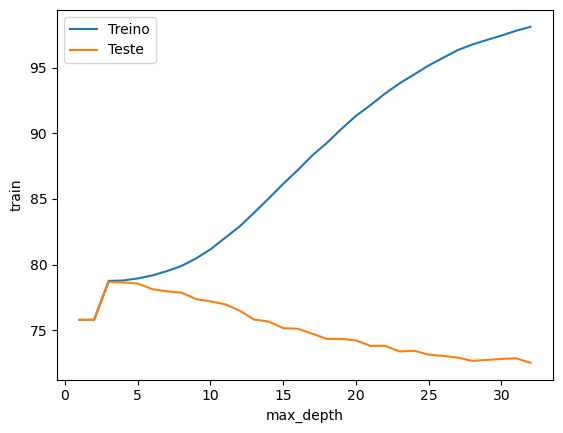

In [21]:
# TRANSFORMANDO O DATAFRAME EM GRAFICO UTILIZANDO O SEABORN
sns.lineplot(resultados, x= 'max_depth', y= 'train', label= 'Treino')
sns.lineplot(resultados, x= 'max_depth', y= 'test', label= 'Teste')

#### Nele, podemos analisar que conforme aumentamos o max_depth, a média do treino vai ficando cada vez melhor, chegando a quase 100%. Porém, em determinado momento, o algoritmo começa a ficar tão exato para o modelo que deixa de ser adequado para os testes, com a média sendo cada vez menor.<br>Esse tipo de cenário é chamado de overfitting.<br><br>Overfit: quando um modelo estatístico se ajusta muito bem ao conjunto de dados anteriormente observado, mas se mostra ineficaz para prever novos resultados. Em outras palavras, ficou "perfeito" para o treino e ruim para o teste.

In [22]:
# VISUALIZANDO QUAL TESTE SE SAIU MELHOR
resultados.sort_values('test', ascending= False).head(10)

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204
10,11,82.032490,76.971552
11,12,82.894797,76.494399


## <br>**Explorando hiper parametros em 2 dimensoes**
#### 2 dimensoes = 2 hiper parametros

#### Como o próprio max_depth, outro exemplo seria min_samples_leaf, que é número mínimo de elementos (samples) em uma folha.<br>As folhas são os últimos nós de uma árvore de decisão, a partir dos quais não ocorrem mais decisões. Um exemplo de uma árvore "perfeita" seria aquela em que todas as suas folhas contivessem somente um elemento - ou seja, na qual cada elemento tivesse uma classificação específica.<br>Mas não queremos que o número de samples seja muito baixo, pois isso faria com que o nosso algoritmo ficasse muito específico para o treino, não conseguindo generalizar tão bem para os testes. É para isso que serve o hiperparâmetro min_samples_leaf.<br><br>Nosso objetivo agora é explorarmos ambos os espaços de parâmetros, max_depth e min_samples_leaf, com diversos valores discretos.

In [23]:
# PASSANDO O HIPER PARAMETRO min_samples_leaf PARA O DECISION TREE CLASSIFIER E CRIANDO NOVA FUNCAO PARA GERAR OS RESULTADOS
def run_tree_classifier (max_depth, min_samples_leaf):
    SEED= 301
    np.random.seed(SEED)
    cv_generator= GroupKFold(n_splits= 10)
    model= DecisionTreeClassifier(max_depth= max_depth, min_samples_leaf= min_samples_leaf)
    results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= True)
    train_score= results['train_score'].mean()*100
    test_score= results['test_score'].mean()*100
    #print("max_depth= %d, min_samples_leaf= %d - Means= train: %.2f, test: %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
    tabela= [max_depth, min_samples_leaf, train_score, test_score]
    return tabela

# Como queremos rodar dois valores por vez, não usaremos list comprehension, pois os resultados não seriam tão facilmente legíveis.
# Vamos começar passando resultados = [] e, depois, criaremos um for max_depth in range(1,33) que culmina em for min_samples_leaf in range(1,33).
def busca():
    resultados= []
    for max_depth in range(1, 33):                  # Rodar esse código todo vai demorar. Como não queremos isso, ao invés de testarmos todo o espaço
        for min_samples_leaf in [32, 64, 128, 256]: # do parâmetro min_samples_leaf, rodaremos apenas uma lista com alguns valores: 32, 64, 128, 256.
            tabela= run_tree_classifier(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados= pd.DataFrame(resultados, columns= ['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados= busca()
resultados

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219
...,...,...,...,...
123,31,256,78.898753,77.848502
124,32,32,80.891161,76.844252
125,32,64,79.788793,77.302229
126,32,128,79.212171,78.221828


In [24]:
# VISUALIZANDO QUAL TESTE SE SAIU MELHOR
resultados.sort_values('test', ascending= False)

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633
...,...,...,...,...
5,2,64,75.791169,75.784219
4,2,32,75.791169,75.784219
3,1,256,75.791169,75.784219
2,1,128,75.791169,75.784219


#### Existe uma dificuldade de apreendermos exatamente o que está acontecendo nesses dados: primeiro, porque a tabela é enorme; e também porque estamos omitindo diversos valores possíveis do nosso teste. Será que o resultado seria melhor se tivéssemos escolhido, por exemplo, min_samples_leaf = 57? E min_samples_leaf = 300? Testar todas as possibilidades consome muito processamento. Uma das abordagens possíveis - claramente a mais complexa -, seria paralelizar esse processamento, distribuindo-o em várias máquinas.<br><br>Outra maneira de tentarmos visualizar se existem espaços de parâmetros melhores para o nosso algoritmo é procurarmos uma relação entre o resultado de teste e esses parâmetros por meio de uma análise de correlação. O próprio Pandas nos disponibiliza esse tipo de análise estatística tradicional.

In [25]:
# TESTANDO A CORRELACAO DOS PARAMETROS COM OS RESULTADOS DE TESTE
corr= resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


<Axes: >

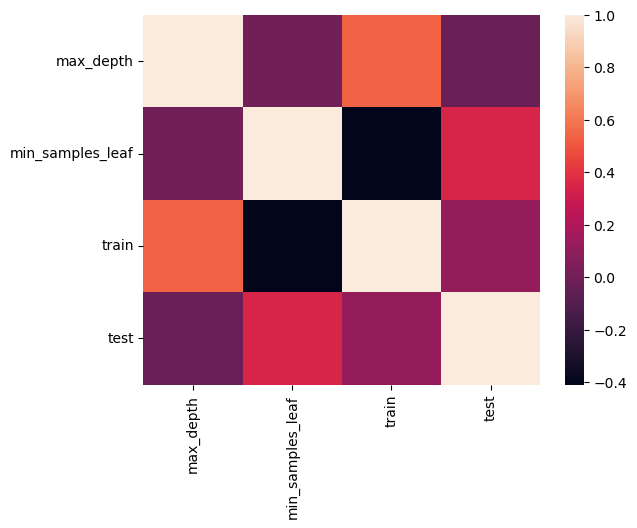

In [26]:
# PLOTANDO GRAFICOS PARA TENTAR VISUALIZAR A CORRELACAO
sns.heatmap(corr)

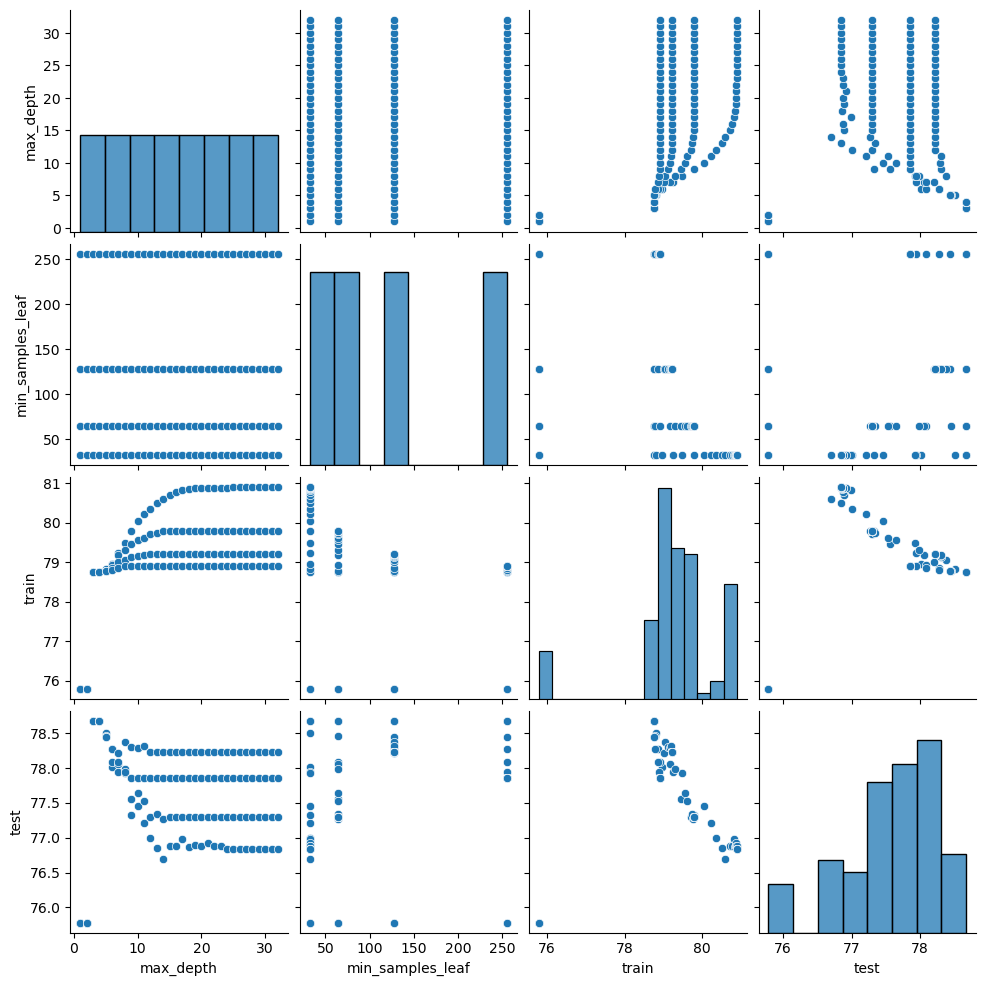

In [27]:
sns.pairplot(resultados)
# pd.plotting.scatter_matrix(resultados) <- bascicamente o mesmo grafico, porem utilizando o pandas

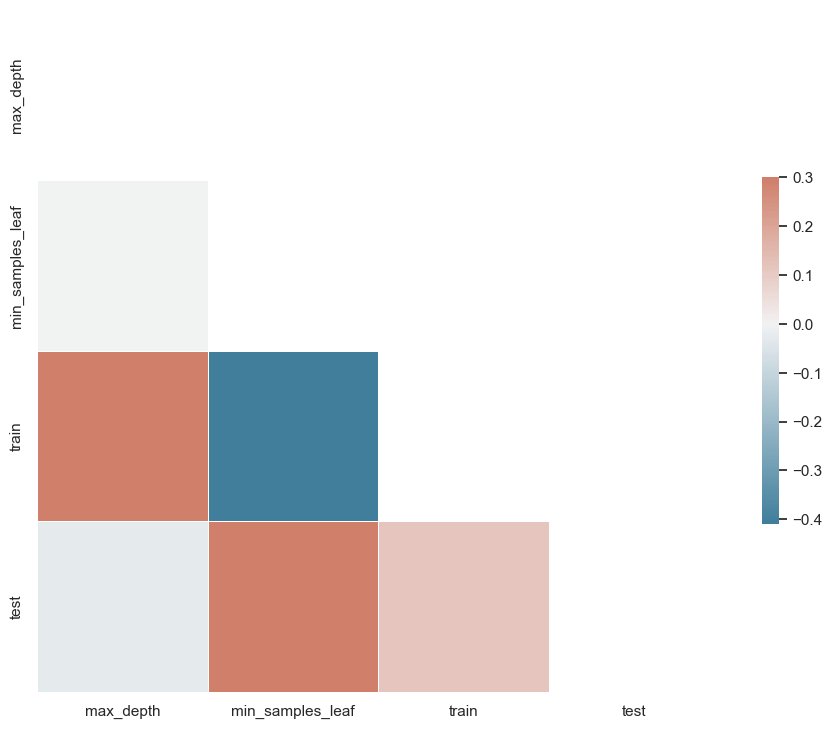

In [28]:
# FUNCAO PARA PLOTAR O HEATMAP DE CORRELACAO PARA NAO PRECISAR FICAR REESCREVENDO O CODIGO
def grafico_corr():
    sns.set_theme(style="white") 
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
grafico_corr()

#### Repare que somente os dados que nos interessam (ou seja, aqueles que não são equivalentes) são plotados com cores na matriz. Nela, percebemos que parece existir uma correlação muito forte entre test e min_samples_leaf - quanto maior o min_samples_leaf, maior a qualidade do test.<br>Com esses dados em mãos, podemos então testar outros valores. Como obtivemos resultados melhores com 128 e 256, vamos mantê-los, e rodar outros numeros (192 e 512).<br><br>Isso nao garante que encontraremos o melhor dos resultados, essa é uma maneira de tentarmos encontrar os valores que mais otimizam o nosso estimador, com o menor índice de erro e o maior nível de qualidade. Fizemos isso com dois parâmetros, mas é possível trabalhar com um número ainda maior!

In [29]:
def busca():
    resultados= []
    for max_depth in range(1, 33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela= run_tree_classifier(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados= pd.DataFrame(resultados, columns= ['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados= busca()
resultados.sort_values('test', ascending= False)

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633
...,...,...,...,...
5,2,192,75.791169,75.784219
4,2,128,75.791169,75.784219
3,1,512,75.791169,75.784219
2,1,256,75.791169,75.784219


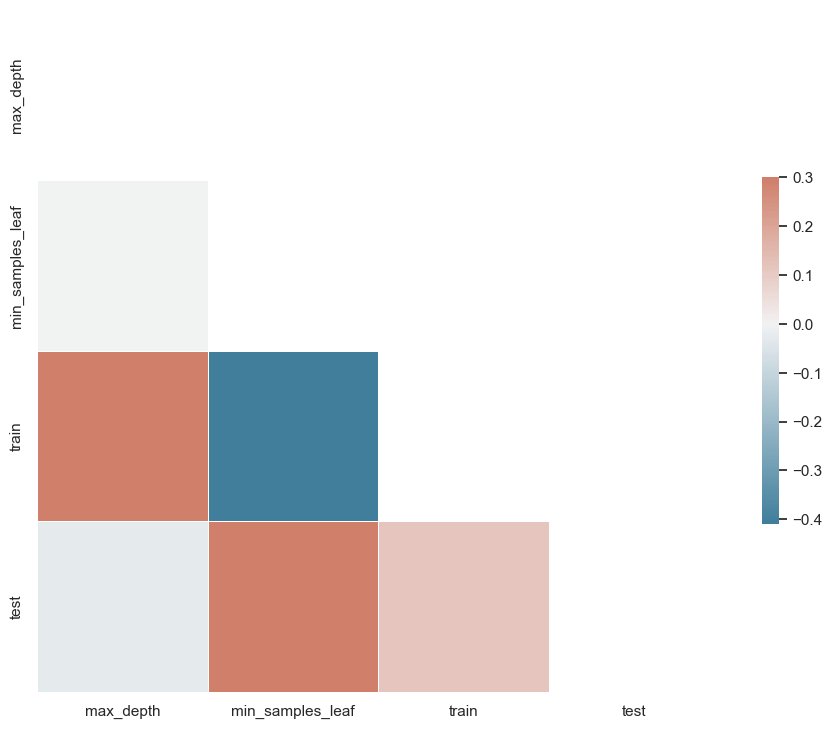

In [30]:
grafico_corr()

## <br> **Explorando hiper parametros em 3 dimensoes**
#### 3 dimensoes = 3 hiper parametros

####  Exploramos um espaço de 2 dimensões, atrelado a 2 parâmetros. Mesmo assim, não exploramos todo o espaço de parâmetros, e mesmo que tenhamos encontrado valores que parecem razoáveis, não temos garantia de que são os melhores possíveis. Dessa vez, vamos trabalharemos com min_samples_split. Antes, estávamos explorando o mínimo de samples em um nó final (a nossa "folha"), e agora exploraremos o mínimo de "quebras" (splits) que podemos ter no meio da árvore.

In [31]:
# REALIZANDO ALTERACOES PARA ADICIONAR O min_samples_split
def run_tree_classifier (max_depth, min_samples_leaf, min_samples_split):
    SEED= 301
    np.random.seed(SEED)
    cv_generator= GroupKFold(n_splits= 10)
    model= DecisionTreeClassifier(max_depth= max_depth, min_samples_leaf= min_samples_leaf, min_samples_split= min_samples_split)
    results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= True)
    train_score= results['train_score'].mean()*100
    test_score= results['test_score'].mean()*100
    #print("max_depth= %d, min_samples_leaf= %d, min_samples_split= %d - Means= train: %.2f, test: %.2f" % (max_depth, min_samples_leaf, min_samples_split, train_score, test_score))
    tabela= [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
    return tabela

def busca():
    resultados= []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]: #nao sei pq o prof voltou a usar esses valores, porem tambem usarei para obter os mesmos resultados
            for min_samples_split in [32, 64, 128, 256]:
                tabela= run_tree_classifier(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados= pd.DataFrame(resultados, columns= ['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test'])
    return resultados

resultados= busca()
resultados.sort_values('test', ascending= False)

,max_depth,min_samples_leaf,min_samples_split,train,test
63,4,256,256,78.750993,78.672633
48,4,32,32,78.750993,78.672633
34,3,32,128,78.750993,78.672633
35,3,32,256,78.750993,78.672633
36,3,64,32,78.750993,78.672633
...,...,...,...,...,...
22,2,64,128,75.791169,75.784219
21,2,64,64,75.791169,75.784219
19,2,32,256,75.791169,75.784219
18,2,32,128,75.791169,75.784219


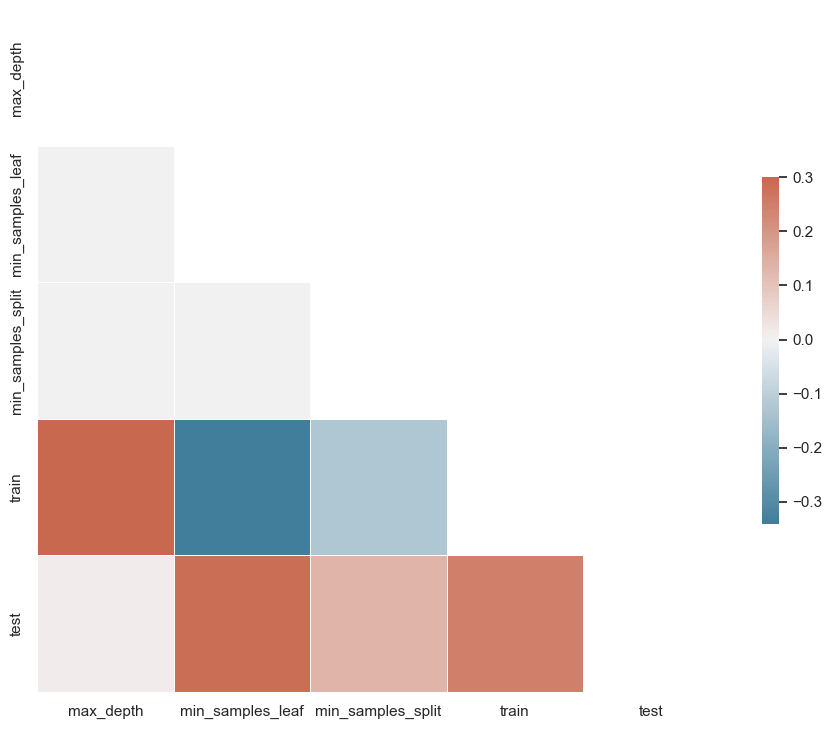

In [32]:
corr= resultados.corr()
grafico_corr()

#### Outro fator que pode ser analisado é o tempo que a máquina virtual leva para treinar o algoritmo. O próprio cross_validate() tem, entre os seus resultados, a cronometragem do tempo. Entao bastaria adicionar os valores a tabela e imprimir para ver: "Olha, por mais que esses algoritimos aqui entreguem a mesma qualidade, um é muito mais rapido que o outro".

In [33]:
# ADICIONANDO AS VARIAVEIS fit_time E score_time A TABELA
def run_tree_classifier (max_depth, min_samples_leaf, min_samples_split):
    SEED= 301
    np.random.seed(SEED)
    cv_generator= GroupKFold(n_splits= 10)
    model= DecisionTreeClassifier(max_depth= max_depth, min_samples_leaf= min_samples_leaf, min_samples_split= min_samples_split)
    results= cross_validate(model, x_azar, y_azar, cv= cv_generator, groups= dados['modelo'], return_train_score= True)
    fit_time= results['fit_time'].mean() # fit_time-> por ser um valor referente a tempo, nao tem por que multiplicar por 100
    score_time= results['score_time'].mean() # score_time-> por ser um valor referente a tempo, nao tem por que multiplicar por 100
    train_score= results['train_score'].mean()*100
    test_score= results['test_score'].mean()*100
    #print("max_depth= %d, min_samples_leaf= %d, min_samples_split= %d - Means= train: %.2f, test: %.2f" % (max_depth, min_samples_leaf, min_samples_split, train_score, test_score))
    tabela= [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela

def busca():
    resultados= []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]: #nao sei pq o prof voltou a usar esses valores, porem tambem usarei para obter os mesmos resultados
            for min_samples_split in [32, 64, 128, 256]:
                tabela= run_tree_classifier(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados= pd.DataFrame(resultados, columns= ['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return resultados

resultados= busca()
resultados.sort_values('test', ascending= False)

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.013058,0.000910
48,4,32,32,78.750993,78.672633,0.013509,0.000908
34,3,32,128,78.750993,78.672633,0.011787,0.000804
35,3,32,256,78.750993,78.672633,0.011407,0.000900
36,3,64,32,78.750993,78.672633,0.011080,0.000914
...,...,...,...,...,...,...,...
22,2,64,128,75.791169,75.784219,0.008945,0.000903
21,2,64,64,75.791169,75.784219,0.008385,0.000907
19,2,32,256,75.791169,75.784219,0.008149,0.001009
18,2,32,128,75.791169,75.784219,0.007406,0.000708


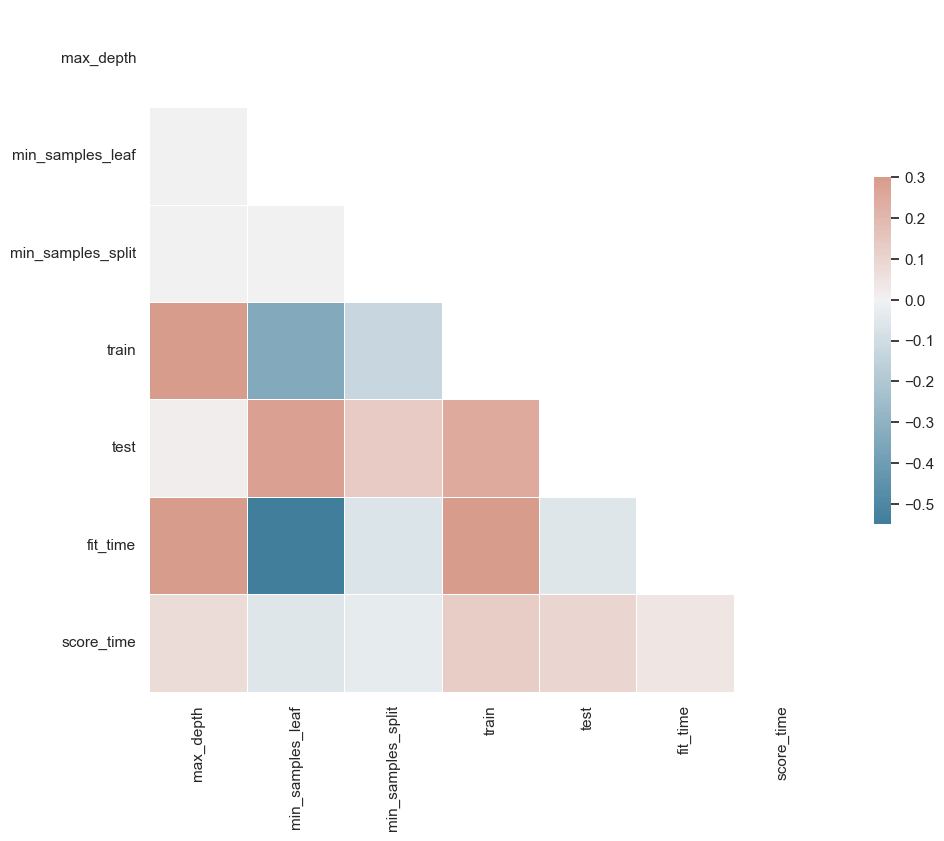

In [34]:
corr= resultados.corr()
grafico_corr()

#### Existe uma pequena diferença entre os tempos de treino e os treinos de teste. Nesse caso, nosso treino é tão rápido que essas diferenças são insignificantes. Porém, se tivéssemos um algoritmo que demora 30 minutos para fazer o treinamento e no qual o tempo de teste fosse muito alto, talvez valesse a pena escolhermos os valores com base nesses resultados.<br>Além dos 3 parâmetros que analisamos até agora, o DecisionTreeClassifier possui vários outros, a exemplo do critério de análise da árvore (como e/ou quando quebrar). Esse parâmetro pode receber dois diferentes valores, como gini ou entropy.<br><br>Os parâmetros de um algoritmo estimador não precisam ser discretos como os que estudados até o momento. Por exemplo, existem casos em que trabalhamos com escala logarítmica ou exponencial, e é mais interessante explorar valores mais altos ou mais baixos. Ou seja, existem vários tipos de espaços de parâmetros que podem ser explorados.

## <br> **Explorando espaco de hiper parametros com Grid Search**

#### Agora que aprendemos a trabalhar com 3 parâmetros, lembre-se que é possível utilizar 4, 5 ou dezenas de parâmetros diferentes. Na prática, não há como explorar todas as possibilidades, portanto a ideia é explorarmos somente uma seleção delas - assim como estamos fazendo nesse curso. Com todo o esforço que isso demanda, seria ideal se tivéssemos uma biblioteca que já fizesse esse processo de otimização do nosso modelo, e o próprio SKLearn possui o GridSearchCV (grid search cross validation).<br><br>Grid Search é um método tradicional usado para ajuste de hiperparâmetros em machine learning. Ele tenta exaustivamente cada combinação dos valores de hiperparâmetros fornecidos para encontrar o melhor modelo.

In [35]:
# CRIANDO O ESPACO DE PARAMETROS E DEFININDO O GridSearchCV
# O espaço de parâmetros em machine learning é o conjunto de todos os possíveis valores que os hiperparâmetros de um modelo podem assumir, resumindo, 
# o espaço de parâmetros é como um mapa de todas as possíveis configurações de um modelo e quando eu passo uma lista com todos essas possiveis
# configuracoes/hiperparametros eu quero que que o Grid Search teste com cada um desses.

SEED= 301
np.random.seed(SEED)

parameters_space= { # 4 dimensoes diferentes
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5],
    'min_samples_leaf' : [32, 64, 128],
    'min_samples_split' : [32, 64, 128]
}

grid= GridSearchCV(DecisionTreeClassifier(), parameters_space, cv= GroupKFold(n_splits= 10))
# O GridSearchCV apos definido funcionara como se fosse um modelo, portanto, podemos fazer grid.fit(), que irá rodar o cross validation dentro dele. 
# Passaremos a ele os nossos dados (x_azar e y_azar) e os grupos (dados['modelo']).
grid.fit(x_azar, y_azar, groups= dados['modelo'])
# O proprio GridSearchCV devolve como atributo um dicionario com cabeçalhos e valores atribuidos que podem ser importados a um pandas DataFrame.
resultados= pd.DataFrame(grid.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011084,0.000562,0.001112,3.040764e-04,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.011036,0.000412,0.001036,2.775628e-04,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.010880,0.000423,0.001000,5.309834e-07,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.011037,0.000323,0.000973,2.989187e-04,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.011009,0.000531,0.001136,3.068480e-04,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
5,0.011121,0.000476,0.001093,1.138860e-04,gini,3,64,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
6,0.010697,0.000593,0.001152,2.988376e-04,gini,3,128,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
7,0.010827,0.000503,0.001072,1.037717e-04,gini,3,128,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
8,0.010950,0.000549,0.001144,2.967852e-04,gini,3,128,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.784080,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
9,0.016237,0.000467,0.001031,4.242257e-04,gini,5,32,32,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.804757,...,0.782090,0.780142,0.797809,0.762866,0.772727,0.77551,0.789326,0.785016,0.012037,19


In [36]:
# VISUALIZANDO OS MELHORES PARAMETROS E O MELHOR SCORE
display(grid.best_params_,
        grid.best_score_ * 100)

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

78.67263337284332

In [37]:
# VISUALIZANDO O MELHOR MODELO
best_grid= grid.best_estimator_
best_grid

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [38]:
# TESTANDO O "MELHOR ESTIMADOR" PARA VER O QUAO BEM ELE VAI SE SAIR NO MUNDO REAL

# grid_predicts= best_grid.predict(x_azar)
# accuracy= accuracy_score(grid_predicts, y_azar)

print("Accuracy para os dados foi %.2f%%" % (best_grid.score(x_azar, y_azar)*100))

Accuracy para os dados foi 78.75%


#### Utilizamos o GridSearchCV do SKLearn para encontrarmos o melhor conjunto de hiperparâmetros em um espaço definido, de modo a otimizar a nossa métrica (accuracy). Quando tentamos analisar quão bem nosso algoritmo se sairia no mundo real, pegamos o melhor conjunto (representado por best_grid) e utilizamos um predict() em cima de x_azar - ou seja, com todos os dados e uma única vez. Porém, durante o nosso processo de aprendizado, utilizamos o cross validation, e existem alguns cuidados que devemos tomar a esse respeito.

#### Na documentação do SKLearn, encontramos uma seção sobre nested versus non-nested cross-validation. O texto afirma que quando estamos utilizando hiperparâmetros, fazendo, por exemplo, o GridSearchCV junto com o cross_validation_score, não devemos descobrir a nossa métrica por meio do predict(), mas sim com outro cross_valiation_score.<br>Utilizar o predict() acaba sendo muito otimista, pois acabamos incorrendo em um vício sobre os dados que já tínhamos visto. Portanto, essa abordagem deve ser evitada:<br><br>grid_predicts= best_grid.predict(x_azar)<br>accuracy= accuracy_score(grid_predicts, y_azar)

## <br>Como ter uma estimativa sem o vício dos dados que eu já vi

#### No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation.

In [39]:
# NESTED CROSS VALIDATION COM GROUP KFOLD BUG

# from sklearn.model_selection import cross_val_score
# cross_val_score(grid, x_azar, y_azar, cv= GroupKFold(n_splits= 10), groups= dados['modelo'])
# Tentando rodar esse código, receberemos um erro afirmando que o valor de groups não deve ser none, como se não tivéssemos passado nenhum valor para 
# os grupos. Ou seja, de alguma forma groups não está chegando em GroupKFold() - e é exatamente isso que está acontecendo.
# Na verdade, isso ocorre por conta de um bug - o GroupKFold falha na validação cruzada aninhada, e existe até um tópico no GitHub do scikit sobre esse 
# problema. É um bug antigo (o tópico foi criado em 2016), mas continua em aberto, pois é razoavelmente complicado implementar a correção dele.

#### Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos. Como alternativa, usaremos o KFold comum, que precisa ser importado de sklearn.model_selection.

In [40]:
# NESTED CROSS VALIDATION COM KFOLD AO INVES DO GROUP KFOLD
# REALIZANDO A TROCA PARA O KFOLD
SEED= 301
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5],
    'min_samples_leaf' : [32, 64, 128],
    'min_samples_split' : [32, 64, 128]
}

grid= GridSearchCV(DecisionTreeClassifier(), parameters_space, cv= KFold(n_splits= 10, shuffle= True))
grid.fit(x_azar, y_azar)

resultados= pd.DataFrame(grid.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011206,0.000663,0.001116,3.011479e-04,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
1,0.010943,0.000477,0.001143,2.898560e-04,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
2,0.011179,0.000535,0.001001,1.000506e-06,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
3,0.011029,0.000328,0.001001,2.762702e-04,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
4,0.011057,0.000566,0.001112,3.029834e-04,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
5,0.010974,0.000501,0.000888,3.647015e-04,gini,3,64,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
6,0.011088,0.000367,0.001029,7.654953e-05,gini,3,128,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
7,0.010934,0.000621,0.001158,3.048274e-04,gini,3,128,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
8,0.010965,0.000393,0.001150,2.960319e-04,gini,3,128,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
9,0.016383,0.000613,0.001073,1.130783e-04,gini,5,32,32,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.767,...,0.775,0.812,0.787,0.796,0.787,0.769,0.779,0.7849,0.013487,31


In [41]:
scores= cross_validate(grid, x_azar, y_azar, cv= KFold(n_splits= 10, shuffle= True))
#‘cross_validate' returns evaluation metrics and other auxiliary information, whereas 
#‘cross_val_score' returns only the evaluation metrics.
media= scores['test_score'].mean()*100
desvio_padrao= scores['test_score'].std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))

Accuracy mean: 78.69
Accuracy interval: [76.13, 81.25]


In [42]:
from sklearn.model_selection import cross_val_score
scores= cross_val_score(grid, x_azar, y_azar, cv= KFold(n_splits= 10, shuffle= True))
#‘cross_validate' returns evaluation metrics and other auxiliary information, whereas 
#‘cross_val_score' returns only the evaluation metrics.
media= scores.mean()*100
desvio_padrao= scores.std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))

Accuracy mean: 78.69
Accuracy interval: [76.41, 80.97]


In [43]:
best_grid

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

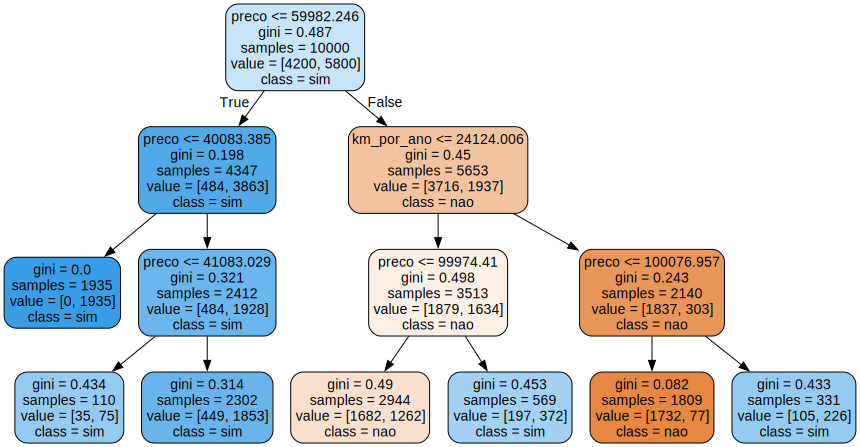

In [44]:
# VISUALIZANDO A ARVORE DO MELHOR ESTIMADOR
best_grid= grid.best_estimator_
features= x_azar.columns
dot_data= export_graphviz(best_grid, filled= True, rounded= True, class_names= ['nao', 'sim'], feature_names= features)
graphviz.Source(dot_data)

#### Com isso, terminamos nosso primeiro processo exploratório de otimização dos nossos modelos. Repare que o SKLearn dá um nome muito interessante para esse processo de validação e otimização de hiperparâmetros: é quando estamos selecionando o nosso modelo ou ***model selection***.<br><br>Para selecionarmos o melhor estimador, dependemos da validação cruzada e dos hiperparâmetros - ou seja, de buscar os parâmetros ideias para o modelo, seja por meio do GridSearchCV, seja por outras estratégias.

# <br> **Part 2: Optimization with Randomized Search**

## **Busca aleatoria: Random Search**

In [5]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
# EXPLORANDO ESPACO DE PARAMETROS ATRAVES DO RandomizedSearchCV AO INVES DO GridSearchCV
SEED= 301
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5],
    'min_samples_leaf' : [32, 64, 128],
    'min_samples_split' : [32, 64, 128]
}

#n_iter = numero de interacoes, ou seja, determina o numero de vezes o RandomizedSearchCV vai ser executado.
random= RandomizedSearchCV(DecisionTreeClassifier(), parameters_space, cv= KFold(n_splits= 10, shuffle= True), n_iter= 16, random_state= SEED)
random.fit(x_azar, y_azar)

resultados= pd.DataFrame(random.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015598,0.000606,0.001037,0.000468,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.767,...,0.775,0.807,0.792,0.796,0.790,0.769,0.779,0.7854,0.013032,7
1,0.011297,0.000404,0.001123,0.000324,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
2,0.010889,0.000432,0.001097,0.000428,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
3,0.019170,0.000635,0.001189,0.000310,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.767,...,0.775,0.809,0.792,0.796,0.790,0.769,0.779,0.7852,0.012960,10
4,0.019156,0.000869,0.001058,0.000080,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.767,...,0.775,0.809,0.792,0.796,0.790,0.769,0.779,0.7852,0.012960,10
5,0.012851,0.000601,0.001017,0.000038,32,64,3,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.767,...,0.774,0.813,0.792,0.796,0.790,0.780,0.779,0.7870,0.013229,1
6,0.019457,0.000536,0.001099,0.000298,32,32,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.767,...,0.775,0.812,0.787,0.796,0.787,0.769,0.779,0.7849,0.013487,14
7,0.018257,0.000597,0.001125,0.000207,128,128,5,entropy,"{'min_samples_split': 128, 'min_samples_leaf':...",0.767,...,0.775,0.807,0.792,0.796,0.790,0.769,0.779,0.7854,0.013032,7
8,0.016051,0.000626,0.001161,0.000495,64,64,5,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.767,...,0.775,0.809,0.792,0.796,0.790,0.769,0.779,0.7852,0.012960,10
9,0.016244,0.000485,0.001143,0.000297,128,32,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.767,...,0.775,0.812,0.787,0.796,0.787,0.769,0.779,0.7849,0.013487,14


In [47]:
# REALIZANDO NESTED CROSS VALIDATION PARA VISUALIZAR O QUAO BEM FOI O MELHOR ESTIMADOR DO RandomizedSearchCV
scores= cross_validate(random, x_azar, y_azar, cv= KFold(n_splits= 10, shuffle= True))
media= scores['test_score'].mean()*100
desvio_padrao= scores['test_score'].std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))

Accuracy mean: 78.69
Accuracy interval: [76.18, 81.20]


In [48]:
melhor= random.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)

#### Nós exploramos aleatoriamente o nosso espaço de parâmetros, mas fizemos isso de maneira bem restrita. Anteriormente, devido às limitações de processamento do GridSearchCV (principalmente em relação ao tempo), nós utilizamos somente 36 combinações.<br>Porém, seria mais interessante explorarmos ainda mais parâmetros no nosso algorítimo - por exemplo, um max_depth que recebesse 10, 20, 30 ou até que não tivesse limites (o que é possível com None).<br><br>A ideia é executarmos novamente o RandomizedSearchCV, mas com diferentes customizações nesse espaço de parâmetros. Por exemplo, em max_depth, ao invés de termos somente os valores 3 e 5, teremos um conjunto discreto de números inteiros (3, 5, 10, 15, 20, 30) com a adição do valor None.

## **Customizando o espaco de hiper parametros**

In [33]:
from scipy.stats import randint

In [161]:
# EXPLORANDO ESPACO DE PARAMETROS, POREM COM DIFERNTES E DIVERSAS CUSTOMIZACOES DE PARAMETROS
SEED= 301
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10, 15, 20, 30, None],
    'min_samples_leaf' : randint(32, 128), # definindo para gerar um numero inteiro aleatorio tanto para min_samples_leaf,
    'min_samples_split' : randint(32, 128) # como para min_samples_split (randint()).
}

# diminuirei o numero de splits no KFold, pois o prof diminui na aula e quero obter os mesmo resultados.
random= RandomizedSearchCV(DecisionTreeClassifier(), parameters_space, cv= KFold(n_splits= 5, shuffle= True), n_iter= 16, random_state= SEED)
random.fit(x_azar, y_azar)

resultados= pd.DataFrame(random.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012003,0.000523,0.001256,3.763753e-04,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.020302,0.000831,0.001028,4.765166e-05,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.018388,0.000577,0.001157,5.036892e-04,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.024797,0.001563,0.001225,3.990551e-04,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.017989,0.000631,0.001611,4.909417e-04,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7
5,0.029147,0.001788,0.001001,7.294206e-07,entropy,20,52,80,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.7670,0.7780,0.7755,0.7865,0.7665,0.7747,0.007447,15
6,0.017476,0.000615,0.001260,3.825597e-04,entropy,5,73,72,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
7,0.019562,0.000601,0.001461,4.667325e-04,gini,None,101,52,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7755,0.7750,0.7870,0.7820,0.7765,0.7792,0.004632,9
8,0.019423,0.000713,0.001097,1.053801e-04,gini,10,108,110,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7760,0.7740,0.7970,0.7815,0.7765,0.7810,0.008373,4
9,0.020818,0.000988,0.001207,2.846004e-04,gini,30,88,78,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7745,0.7725,0.7880,0.7815,0.7705,0.7774,0.006468,13


In [51]:
# REALIZANDO NESTED CROSS VALIDATION
scores= cross_validate(random, x_azar, y_azar, cv= KFold(n_splits= 5, shuffle= True))
media= scores['test_score'].mean()*100
desvio_padrao= scores['test_score'].std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))
melhor= random.best_estimator_
melhor

Accuracy mean: 78.71
Accuracy interval: [77.49, 79.93]


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)

In [54]:
# ORDENANDO PELO TEST SCORE
resultados_ordenados_testscore= resultados.sort_values('mean_test_score', ascending= False)
resultados_ordenados_testscore

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011870,0.000573,0.001256,0.000370,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
6,0.016888,0.000448,0.001208,0.000406,entropy,5,73,72,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
12,0.014353,0.000441,0.001356,0.000377,gini,5,64,67,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
8,0.019294,0.000760,0.001104,0.000127,gini,10,108,110,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7760,0.7740,0.7970,0.7815,0.7765,0.7810,0.008373,4
13,0.018851,0.001303,0.001252,0.000396,gini,10,125,59,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7745,0.7745,0.7995,0.7790,0.7745,0.7804,0.009708,5
11,0.019266,0.000746,0.001192,0.000153,gini,15,103,96,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7755,0.7750,0.7915,0.7810,0.7765,0.7799,0.006176,6
4,0.018126,0.000604,0.001141,0.000183,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7
2,0.018415,0.000738,0.001256,0.000385,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
7,0.019406,0.001052,0.001061,0.000092,gini,None,101,52,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7755,0.7750,0.7870,0.7820,0.7765,0.7792,0.004632,9
15,0.022682,0.001323,0.001053,0.000097,entropy,15,104,88,"{'criterion': 'entropy', 'max_depth': 15, 'min...",0.7755,0.7745,0.7915,0.7810,0.7730,0.7791,0.006763,10


In [163]:
# ITERANDO AS LINHAS DO DATAFRAME ATRAVES DO iterroes() PARA MELHOR VISUALIZACAO E INTERPRETACAO
# Essa é uma forma resumida de imprimir os resultados que recebíamos na tabela do pandas, de forma limpa (mean_test_score, std_test_score, params).
# iterrows = Itera sobre linhas do DataFrame como pares (índice, série).
# ao inves de colocar 'index, linha' poderia ter colocado '_, linha' para ignorar o valor do indice.
for index, linha in resultados_ordenados_testscore.iterrows():
    print("%.3f +-(%.3f) %s" % (linha['mean_test_score'], linha['std_test_score']*2, linha['params']))

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +-(0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +-(0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +-(0.014) {'criterion': 'entropy', 'max_depth

## **Uma exploracao mais a fundo de forma aleatoria**

#### Com 16 combinações, é uma análise razoável. Mas e se quiséssemos explorar um número maior - por exemplo, 64?

In [169]:
# REALIZANDO UMA EXPLORACAO MAIS A FUNDO DE FORMA ALEATORIA (n_iter= 64 ao inves de 16)
# Essa exploração é aleatória, e não é uma prática comum mudarmos o SEED para encontrar valores ótimos - já que, como podemos perceber, os valores 
# são bastante próximos entre si. Na verdade, esses resultados também poderiam ser muito distantes entre si, dependendo de várias condições.
SEED= 564 # mudei o seed de 301 para 564 pois o prof tambem mudou para provar o que foi dito acima.
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10, 15, 20, 30, None],
    'min_samples_leaf' : randint(32, 128),
    'min_samples_split' : randint(32, 128)
}

random= RandomizedSearchCV(DecisionTreeClassifier(), parameters_space, cv= KFold(n_splits= 5, shuffle= True), n_iter= 64, random_state= SEED)
random.fit(x_azar, y_azar)

resultados= pd.DataFrame(random.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025035,0.000285,0.001260,0.000385,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,0.7745,0.7735,0.7620,0.7625,0.7701,0.006583,62
1,0.009800,0.000478,0.001029,0.000048,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7855,0.7915,0.7905,0.7765,0.7869,0.005607,1
2,0.018888,0.000848,0.001109,0.000124,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,0.7745,0.7785,0.7720,0.7875,0.7780,0.005273,18
3,0.029162,0.000536,0.001057,0.000094,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,0.7780,0.7760,0.7650,0.7655,0.7711,0.005295,57
4,0.022918,0.000842,0.001169,0.000256,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,0.7780,0.7835,0.7695,0.7735,0.7760,0.004669,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.021166,0.000817,0.001056,0.000100,gini,15,76,39,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7765,0.7785,0.7725,0.7705,0.7805,0.7757,0.003709,32
60,0.024140,0.000468,0.000997,0.000004,entropy,10,87,38,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.7840,0.7720,0.7760,0.7700,0.7620,0.7728,0.007222,51
61,0.025104,0.000798,0.001308,0.000375,gini,20,32,93,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7590,0.7745,0.7790,0.7745,0.7825,0.7739,0.008034,45
62,0.014310,0.000522,0.001438,0.000520,gini,5,39,73,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.7905,0.7840,0.7915,0.7910,0.7750,0.7864,0.006320,8


In [171]:
resultados_ordenados_testscore= resultados.sort_values('mean_test_score', ascending= False)
for index, linha in resultados_ordenados_testscore.iterrows():
    print("%.3f +-(%.3f) %s" % (linha['mean_test_score'], linha['std_test_score']*2, linha['params']))

0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +-(0.013) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +-(0.013) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +-(0.014) {'criterion': 'entropy', 'max_depth': 5, 

In [172]:
scores= cross_validate(random, x_azar, y_azar, cv= KFold(n_splits= 5, shuffle= True))
media= scores['test_score'].mean()*100
desvio_padrao= scores['test_score'].std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))
melhor= random.best_estimator_
melhor

Accuracy mean: 78.69
Accuracy interval: [77.64, 79.74]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=53, min_samples_split=60)

## **GridSearchCV x RandomizedSearchCV - 1 comparacao**

#### Até o momento, vínhamos utilizando o DecisionTreeClassifier, um dos diversos classificadores baseados em árvores de decisão. Existem outros classificadores que, ao invés de tentarem uma única árvore, tentam diversas árvores. Um desses, bem famoso, é o ensemble RandomForestClassifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier
import time

In [25]:
# GERANDO O GRIDSEARCH PARA COMPARACOES, POREM COM NOVO ESTIMADOR (RandomForestClassifier()) E NOVOS HIPER PARAMETROS (n_estimators, bootstrap)
SEED= 301
np.random.seed(SEED)

# n_estimators = representa o numero de estimadores que serao criados, o numero de estimadores que serao treinados.
# bootstrap = ao invés do algorítimo tentar treinar os classificadores para todos os dados de treino que estamos passando, correndo o risco de um 
# overfitting, cada árvore é treinada com uma amostra desses dados. O bootstrap permite definir se um mesmo elemento pode fazer parte de diferentes 
# amostras, sim ou nao.
parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'n_estimators' : [10, 100],
    'bootstrap' : [True, False]
}

# Antes de rodarmos o grid, não iremos medir somente a acurácia, mas também o tempo gasto computacionalmente para chegarmos aos nossos modelos. Para 
# isso, importaremos 'time' e passaremos dois momentos: start, quando o treino começa; e end, quando ele termina.
start= time.time()
grid= GridSearchCV(RandomForestClassifier(), parameters_space, cv= KFold(n_splits= 5, shuffle= True))
grid.fit(x_azar, y_azar)
end= time.time()

tempo_gasto= end - start
print("Tempo gasto: %.2f segundos" % tempo_gasto)

resultados= pd.DataFrame(grid.cv_results_)
resultados

Tempo gasto: 195.17 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036400,0.002059,0.002800,3.999234e-04,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.346800,0.005564,0.015600,4.898041e-04,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.036400,0.001497,0.002800,4.001141e-04,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.342000,0.005254,0.015400,4.900571e-04,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.035600,0.002417,0.003000,3.371748e-07,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.624603,0.007963,0.018201,3.998766e-04,False,entropy,5,128,32,100,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7750,0.7575,0.7960,0.7850,0.7625,0.7752,0.014165,45
140,0.061402,0.001851,0.003198,4.008487e-04,False,entropy,5,128,64,10,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7730,0.7545,0.7940,0.7810,0.7650,0.7735,0.013491,84
141,0.631400,0.010032,0.018000,3.234067e-07,False,entropy,5,128,64,100,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7690,0.7585,0.7940,0.7850,0.7625,0.7738,0.013552,81
142,0.063600,0.002417,0.003000,5.761645e-07,False,entropy,5,128,128,10,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7655,0.7570,0.7930,0.7860,0.7615,0.7726,0.014232,94


In [26]:
# VISUALIZANDO OS 5 MELHORES
resultados_ordenados_testscore= resultados.sort_values('mean_test_score', ascending= False)
for index, linha in resultados_ordenados_testscore.head().iterrows():
    print("%.3f +-(%.3f) %s" % (linha['mean_test_score'], linha['std_test_score']*2, linha['params']))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [27]:
# NESTED CROSS VALIDATION COM O GRID
# start= time.time()
# scores= cross_validate(grid, x_azar, y_azar, cv= KFold(n_splits= 5, shuffle= True))
# end= time.time()
# tempo_gasto= end - start

# media= scores['test_score'].mean()*100
# desvio_padrao= scores['test_score'].std()*100

# print("Accuracy mean: %.2f" % (media))
# print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))
# melhor= random.best_estimator_
# melhor

# NAO EXECUTAREI ESSE CODIGO POR CONTA DO TEMPO ABSURDAMENTE ABSURDO QUE LEVARA PARA RODAR

In [28]:
# GERANDO O RANDOMIZEDSEARCH PARA COMPARACOES, POREM COM NOVO ESTIMADOR (RandomForestClassifier()) E NOVOS HIPER PARAMETROS (n_estimators, bootstrap)
SEED= 301
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5],
    'min_samples_split' : [32, 64, 128],
    'min_samples_leaf' : [32, 64, 128],
    'n_estimators' : [10, 100],
    'bootstrap' : [True, False]
}

start= time.time()
random= RandomizedSearchCV(RandomForestClassifier(), parameters_space, cv= KFold(n_splits= 5, shuffle= True), n_iter= 20, random_state= SEED)
random.fit(x_azar, y_azar)
end= time.time()
tempo_gasto= end - start
print("Tempo gasto: %.2f segundos" % (tempo_gasto))

resultados= pd.DataFrame(random.cv_results_)
resultados

Tempo gasto: 28.38 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.381201,0.008494,0.015600,4.900505e-04,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7270,0.7580,0.7950,0.7850,0.7625,0.7655,0.023656,13
1,0.051600,0.004543,0.003200,4.002571e-04,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7425,0.7555,0.7915,0.7745,0.7630,0.7654,0.016687,15
2,0.579200,0.002562,0.018400,4.902520e-04,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7760,0.7585,0.7945,0.7855,0.7625,0.7754,0.013559,3
3,0.038202,0.001326,0.002998,3.443147e-06,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7510,0.7580,0.7725,0.7845,0.7445,0.7621,0.014558,19
4,0.046800,0.002713,0.003000,2.431402e-07,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7755,0.7555,0.7500,0.7725,0.7620,0.7631,0.009723,17
5,0.041200,0.001939,0.002998,3.456329e-06,10,128,64,3,gini,False,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7755,0.7545,0.7655,0.7635,0.7625,0.7643,0.006735,16
6,0.037202,0.002316,0.003000,3.371748e-07,10,64,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7390,0.7585,0.8025,0.7575,0.7535,0.7622,0.021325,18
7,0.384202,0.008448,0.015798,3.991758e-04,100,64,64,3,gini,False,"{'n_estimators': 100, 'min_samples_split': 64,...",0.7750,0.7575,0.7950,0.7855,0.7625,0.7751,0.013948,5
8,0.444800,0.005036,0.015400,4.899404e-04,100,128,32,3,entropy,False,"{'n_estimators': 100, 'min_samples_split': 128...",0.7630,0.7580,0.7940,0.7850,0.7620,0.7724,0.014347,10
9,0.459000,0.010373,0.015800,3.997100e-04,100,32,128,3,entropy,False,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7750,0.7575,0.7945,0.7855,0.7625,0.7750,0.013806,6


In [29]:
# VISUALIZANDO OS 5 MELHORES
resultados_ordenados_testscore = resultados.sort_values('mean_test_score', ascending= False)
for index, linha in resultados_ordenados_testscore.head().iterrows():
    print("%.3f +-(%.3f) %s" % (linha['mean_test_score'], linha['std_test_score'], linha['params']))

0.777 +-(0.013) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.014) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.775 +-(0.014) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.775 +-(0.014) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
0.775 +-(0.014) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}


In [31]:
# NESTED CROSS VALIDATION COM O RANDOMIZED
start= time.time()
scores= cross_validate(random, x_azar, y_azar, cv= KFold(n_splits= 5, shuffle= True))
end= time.time()
tempo_gasto= end - start
print("Tempo gasto: %.2f segundos" % (tempo_gasto))

media= scores['test_score'].mean()*100
desvio_padrao= scores['test_score'].std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))

melhor= random.best_estimator_
melhor

Tempo gasto: 115.59 segundos
Accuracy mean: 76.50
Accuracy interval: [73.98, 79.02]


RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=32,
                       min_samples_split=64)

#### Em cerca de 2 minutos e meio obtivemos os resultados do cross_validation_score() com o RandomizedSearchCV. Enquanto isso, somente com 144 possibilidades, não conseguimos rodar a mesma função com do GridSearchCV remotamente. Imagine então se, para min_samples_split e min_samples_leaf, utilizássemos o parâmetro randint para iterar entre qualquer número entre 32 e 129? Ou mesmo para iterar entre 10 e 101 em n_estimators e entre 3 e 6 em max_depth?<br><br>Nesse caso, teríamos 10.274.628 combinações (91*3*97*97*2*2). Parece inviável, não é? Já com o RandomSearchCV, poderíamos até mesmo controlar o tempo (e o custo computacional) dispensado a essa tarefa. Por exemplo, se levamos cerca de meio minuto para iterar por 20 possibilidades randômicas, podemos estimar que iterar por 80 possibilidades levará cerca de 2 minutos.

In [34]:
# GERANDO O RANDOMIZEDSEARCH, POREM COM n_iter= 80 AO INVES DE 20 E UTILIZANDO randint() NO parameters_space
SEED= 301
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : randint(3, 6),
    'min_samples_split' : randint(32, 129),
    'min_samples_leaf' : randint(32, 129),
    'n_estimators' : randint(10, 101),
    'bootstrap' : [True, False]
}

start= time.time()
random= RandomizedSearchCV(RandomForestClassifier(), parameters_space, cv= KFold(n_splits= 5, shuffle= True), n_iter= 80, random_state= SEED)
random.fit(x_azar, y_azar)
end= time.time()
tempo_gasto= end - start
print("Tempo gasto: %.2f segundos" % (tempo_gasto))

resultados= pd.DataFrame(random.cv_results_)
resultados

Tempo gasto: 96.91 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.336400,0.006469,0.013999,2.547400e-06,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7590,0.7580,0.7890,0.7850,0.7625,0.7707,0.013452,66
1,0.268400,0.003555,0.012600,4.900571e-04,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7760,0.7575,0.7870,0.7730,0.7625,0.7712,0.010386,64
2,0.255600,0.002332,0.012200,3.997565e-04,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7760,0.7590,0.7950,0.7855,0.7625,0.7756,0.013577,16
3,0.169600,0.003611,0.008600,4.898041e-04,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7765,0.7580,0.7940,0.7850,0.7625,0.7752,0.013478,23
4,0.281199,0.002788,0.011799,3.993317e-04,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7765,0.7580,0.7945,0.7860,0.7625,0.7755,0.013766,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.247999,0.006165,0.008001,1.248913e-06,False,entropy,4,42,117,44,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7770,0.7580,0.7880,0.7855,0.7630,0.7743,0.011948,51
76,0.447200,0.005306,0.015000,3.015783e-07,False,gini,5,62,44,82,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7755,0.7575,0.7920,0.7870,0.7625,0.7749,0.013384,37
77,0.080200,0.001600,0.003600,4.898819e-04,False,entropy,5,35,125,12,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7660,0.7650,0.7900,0.7830,0.7695,0.7747,0.009998,41
78,0.363797,0.002854,0.010003,5.774654e-06,False,entropy,5,32,74,54,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7735,0.7575,0.7985,0.7845,0.7615,0.7751,0.015055,28


In [36]:
# VISUALIZANDO OS 5 MELHORES
resultados_ordenados_testscore= resultados.sort_values('mean_test_score', ascending= False)
for index, linha in resultados_ordenados_testscore.head().iterrows():
    print("%.3f +-(%.3f) %s" % (linha['mean_test_score'], linha['std_test_score'], linha['params']))

0.779 +-(0.016) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 72, 'min_samples_split': 96, 'n_estimators': 20}
0.779 +-(0.011) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 38, 'min_samples_split': 106, 'n_estimators': 31}
0.778 +-(0.012) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 111, 'min_samples_split': 104, 'n_estimators': 19}
0.778 +-(0.012) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 37, 'min_samples_split': 120, 'n_estimators': 93}
0.778 +-(0.014) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 81, 'min_samples_split': 59, 'n_estimators': 16}


In [37]:
# NESTED CROSS VALIDATION COM O RANDOMIZED
start= time.time()
scores= cross_validate(random, x_azar, y_azar, cv= KFold(n_splits= 5, shuffle= True))
end= time.time()
tempo_gasto= end - start
print("Tempo gasto: %.2f segundos" % (tempo_gasto))

media= scores['test_score'].mean()*100
desvio_padrao= scores['test_score'].std()*100

print("Accuracy mean: %.2f" % (media))
print("Accuracy interval: [%.2f, %.2f]" % ((media - 2 * desvio_padrao), (media + 2 * desvio_padrao)))

melhor= random.best_estimator_
melhor

Tempo gasto: 403.72 segundos
Accuracy mean: 77.47
Accuracy interval: [75.90, 79.04]


RandomForestClassifier(max_depth=5, min_samples_leaf=72, min_samples_split=96,
                       n_estimators=20)

## **Se eu nao posso ou nao consigo usar cross validation**

#### Agora que fizemos algumas comparações entre o GridSearchCV e o RandomizedSearchCV, vamos analisar alguns casos diferentes. Por exemplo, pode ser que não seja possível, computacionalmente, rodar um cross validation, independentemente do fold. Nesse caso, como faríamos uma otimização de hiperparâmetros sem cross validation?

#### Sem a cross validation, teremos que encontrar outra forma de obter os resultados finais desse algorítimo. Precisaremos, então, de um conjunto de dados nunca visto antes para executar a validação do nosso modelo. Mas como faremos isso se todos os dados foram utilizados no treino e no teste? <br>A resposta na verdade é bem simples: a separação desses dados deve ser feita de antemão. Portanto, antes de treinarmos o modelo com x_azar e y_azar, separaremos uma amostra dos dados para a fase que chamaremos de validação.<br><br>Vamos supor que queremos 60% para treino, 20% para teste (também chamado de "dev teste") e 20% para a validação final. Faremos isso utilizando o train_test_split(), que deverá ser importado do sklearn.model_selection.<br><br><li>0.60 treino</li><li>0.20 teste => dev teste</li><li>0.20 validation</li>

In [41]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [55]:
# DIVIDINDO OS DADOS EM TREINO, TESTE E VALIDACAO
# A separacao do 'test_size' separara os dados em 80% dos dados para treino e 20% para teste, porem como a separacao eh 'train_test_split', ou seja,
# divide os dados apenas em treino e teste e nao em treino, teste e validacao, consideraremos os 20% dos dados separados para o teste como os dados de
# validacao. Os dados separados para o treino (80%) serao os dados para o treino e o teste, enquanto os dados separados para o teste (20%) serao os
# nossos dados para validacao.
SEED= 301
np.random.seed(SEED)

x_train_test, x_validation, y_train_test, y_validation= train_test_split(x_azar, y_azar, test_size= 0.2, stratify= y_azar)

print("x =>", x_train_test.shape, x_validation.shape)
print("y =>", y_train_test.shape, y_validation.shape)

x => (8000, 3) (2000, 3)
y => (8000,) (2000,)


In [56]:
# GERANDO O RANDOMIZEDSEARCH COM AS ALTERACOES PARA REALIZAR A VALIDACAO SEM O CROSS VALIDATION
SEED= 301
np.random.seed(SEED)

parameters_space= {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : randint(3, 6),
    'min_samples_split' : randint(32, 129),
    'min_samples_leaf' : randint(32, 129),
    'n_estimators' : randint(10, 101),
    'bootstrap' : [True, False]
}

split= StratifiedShuffleSplit(n_splits= 1, test_size= 0.25) # test_size = 0.25, pois 20% de 80% sao 25%, fazendo isso mantemos a preporcao 0.6 0.2 0.2
                                                            #                    80% = 100%, 20% = 25%
start= time.time()
random= RandomizedSearchCV(RandomForestClassifier(), parameters_space, cv= split, n_iter= 5)
random.fit(x_train_test, y_train_test)
end= time.time()

tempo_gasto= end - start
print("Tempo gasto: %.2f segundos" % tempo_gasto)

resultados= pd.DataFrame(random.cv_results_)
resultados

Tempo gasto: 1.33 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.275000,0.0,0.015000,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7745,0.7745,0.0,2
1,0.224001,0.0,0.011999,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7735,0.0,5
2,0.210000,0.0,0.013006,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,2
3,0.149994,0.0,0.008000,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7750,0.7750,0.0,1
4,0.227000,0.0,0.012000,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7745,0.0,2


In [60]:
# VALIDANDO OS DADOS
start= time.time()
scores= cross_validate(random, x_validation, y_validation, cv= split)
end= time.time()

tempo_gasto= end - start

print("Tempo gasto: %.2f segundos" % (tempo_gasto))
scores['test_score']

Tempo gasto: 0.34 segundos


array([0.79])